### CNNの学習を行うノートブック

ライブラリのimport

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Dropout,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
w=28
work_dir='data/digits'
classes=list(range(10))
num_classes=len(classes)

model_file="digits-model-w{0}.hd5".format(w)
history_file="digits-history-w{0}.csv".format(w)

train/testデータのnumpy配列ファイルからの読み込みとサイズの確認<br> 
Xは0-1(データ型はfloat16)、yはone-hot encodingにする

In [9]:
n_train=4000
n_test=800
(X_train_full,y_train_full),(X_test_full,y_test_full)=mnist.load_data()
print(X_train_full.shape,y_train_full.shape)
print(X_test_full.shape,y_test_full.shape)

mode="train"
X_train=X_train_full[:n_train].astype('float16').reshape(-1,w,w,1)
X_train/=255
y_train=y_train_full[:n_train]
y_train=to_categorical(y_train,num_classes)

mode="test"
X_test=X_test_full[:n_test].astype('float16').reshape(-1,w,w,1)
X_test/=255
y_test=y_test_full[:n_test]
y_test=to_categorical(y_test,num_classes)

print( X_train.shape )
print( y_train.shape )
print( X_test.shape )
print( y_test.shape )
img_rows=X_train.shape[1]
img_cols=X_train.shape[2]
img_channels=X_train.shape[3]
print("image_size:", img_rows, img_cols)
print("image_channels:", img_channels)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
(4000, 28, 28, 1)
(4000, 10)
(800, 28, 28, 1)
(800, 10)
image_size: 28 28
image_channels: 1


CNNの構築

In [10]:
input_shape=(img_rows,img_cols,img_channels)
model=Sequential()
model.add(Conv2D(16, (3,3), activation='relu', padding='same',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4

CNNの学習

In [11]:
%%time
n_epochs=40
val_split=0.2
batch_size=128
model.compile(loss='categorical_crossentropy', optimizer='rmsprop',
              metrics=['accuracy'])
cl=CSVLogger(history_file)
#fit_log=model.fit(X_train, y_train, batch_size=batch_size,
#                  epochs=n_epochs, validation_split=val_split,
#                  callbacks=[cl])
#if you want to use early stopping, uncomment the following lines
es=EarlyStopping(monitor='val_loss',patience=7,verbose=1)
fit_log=model.fit(X_train, y_train, batch_size=batch_size,
                  epochs=n_epochs, validation_split=val_split,
                  callbacks=[cl, es])

Train on 3200 samples, validate on 800 samples
Epoch 1/40
3200/3200 [==============================] - 3s 907us/sample - loss: 2.1972 - acc: 0.2231 - val_loss: 1.8726 - val_acc: 0.5337
Epoch 2/40
3200/3200 [==============================] - 2s 510us/sample - loss: 1.6344 - acc: 0.4681 - val_loss: 1.1180 - val_acc: 0.6737
Epoch 3/40
3200/3200 [==============================] - 2s 486us/sample - loss: 1.2262 - acc: 0.6016 - val_loss: 0.7483 - val_acc: 0.7950
Epoch 4/40
3200/3200 [==============================] - 2s 483us/sample - loss: 0.9281 - acc: 0.6909 - val_loss: 0.5673 - val_acc: 0.8487
Epoch 5/40
3200/3200 [==============================] - 2s 494us/sample - loss: 0.7656 - acc: 0.7541 - val_loss: 0.4379 - val_acc: 0.8788
Epoch 6/40
3200/3200 [==============================] - 2s 492us/sample - loss: 0.6405 - acc: 0.7969 - val_loss: 0.3668 - val_acc: 0.8950
Epoch 7/40
3200/3200 [==============================] - 2s 514us/sample - loss: 0.5490 - acc: 0.8297 - val_loss: 0.3065 - val

学習経過のグラフ描画

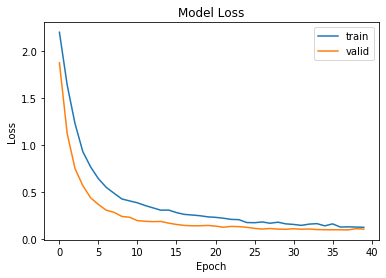

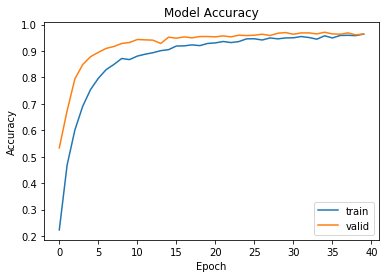

In [12]:
plt.plot(fit_log.history['loss'])
plt.plot(fit_log.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','valid'], loc='best')
plt.show()

plt.plot(fit_log.history['acc'])
plt.plot(fit_log.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','valid'], loc='best')
plt.show()

学習経過のグラフ描画（このようにhistory_fileから読み出すこともできる）

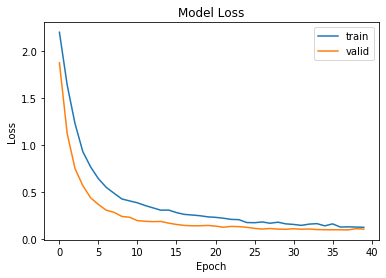

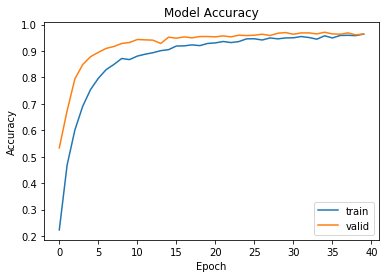

In [13]:
h=np.loadtxt(history_file,delimiter=',',skiprows=1)
epoch=h[:,0]
acc=h[:,1]
loss=h[:,2]
val_acc=h[:,3]
val_loss=h[:,4]

plt.plot(epoch,loss)
plt.plot(epoch,val_loss)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train','valid'], loc='best')
plt.show()

plt.plot(epoch,acc)
plt.plot(epoch,val_acc)
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','valid'], loc='best')
plt.show()

テストデータに対する精度(汎化性能の見積もり)

In [14]:
score=model.evaluate(X_test, y_test, verbose=0)
print('loss=', score[0])
print('accuracy=', score[1])

loss= 0.08452638551592827
accuracy= 0.96875


modelファイルの保存

In [15]:
model.save(model_file)